In [238]:
import os
import pandas as pd
import csv
import re
import numpy as np
import datetime
import pytz
from google.cloud import bigquery
from google.cloud.bigquery import SchemaField


## Process Latest Schema

In [181]:
# LATEST VERSION
# Reading and processing CSV output from MM DB -- CTE results combining meet info
# Use SQL Query 
#WITH test AS (
#          	SELECT * FROM [Results]
#			LEFT JOIN [Athlete] ON [Athlete].[Comp_no] = [Results].[Comp_no]
#			LEFT JOIN [Entries] ON [Entries].[Comp_no] = [Results].[Comp_no] AND [Entries].[Event_numltr]=[Results].[Event_numltr] 
#			JOIN [Divisions] ON [Divisions].[Div_no]  = [Results].[Div_no]
#			JOIN [Team] ON [Results].[Team_no] = [Team].[Team_no]
#
#        )
#        SELECT * FROM test, [Meet]

# Comp_no = TAG ID. Use Comp_no instead of Ath_no due to relay events not being joined as Ath_no for relay=0

# Extracts new columns from MM required for new schema

os.chdir('/Users/veesheenyuen/Desktop/DataScience/SAA/MM/mm_files/2025/')

file="GenericData-SSP Invitational U15 and U18 2025-31May2025-001.csv"


df = pd.read_csv(file)


SCHEMA FIELD	DESCRIPTION	MEET MANAGER FIELD	
RANK	Competition rank	Res_place	NULLABLE
TAG_ID	Comp_no in MM	Comp_no	NULLABLE
FIRST_NAME	First name	First_name	NULLABLE
LAST_NAME	Last name	Last_name	NULLABLE
OTHER_NAME	Middle/preferred/Chinese name	Pref_name	NULLABLE
NAME	Full name	Concatenation of FIRST_NAME, LAST_NAME & OTHER_NAME	REQUIRED
TEAM		Team_name	NULLABLE
SEED		ActualSeed_timeDisplay	NULLABLE
RESULT		Res_markDisplay	REQUIRED
QUALIFICATION	Q or q		NULLABLE
HEAT		Res_heat	NULLABLE
LANE		Res_lane	NULLABLE
WIND	In m/s	Res_wind	NULLABLE
EVENT		Event_name	REQUIRED
DIVISION	Masters, Open, U20/U18, A, B, C etc.	Div_name	NULLABLE
STAGE	Finals, Semis, Heats 	Rnd_ltr	NULLABLE
POINTS		Event_score	NULLABLE
AGE		Ath_age	NULLABLE
GENDER	Male/Female/Mixed	Event_gender	REQUIRED
UNIQUE_ID	Athlete Unique ID	Reg_no	NULLABLE
NATIONALITY		Citizen_of	NULLABLE
DICT_RESULTS	Dictionary of attempts for jumps or names for relay		NULLABLE
YEAR	Year of competition e.g. 2024	Extracted from Meet_start	REQUIRED
COMPETITION	SEA Games etc.	Meet_name	REQUIRED
REGION	Local or International		REQUIRED
DOB		Birth_date	NULLABLE
GROUP			NULLABLE
CATEGORY_EVENT	High level category e.g. Jumps, Throws etc.		NULLABLE
ATHLETE_ID	From MM	Ath_no	NULLABLE
SOURCE	Source url or file		NULLABLE
REMARKS	PB/SB etc.	Res_note	NULLABLE
TIMESTAMP	Upload into BQ TS	Upload timestamp	NULLABLE
VENUE		Meet_location	NULLABLE
DATE	Day and month 	Extracted from Meet_start and Meet _end	NULLABLE
SUB_EVENT	e.g. Dash in Heptathlon (MM field)	MultiSubEvent_name	NULLABLE
SESSION	NSG session ID		NULLABLE
EVENT_CLASS	Weight or heigh class for shot put/hurdles etc. (MM field)	Event_note	NULLABLE
RX_TIME	Reaction time		NULLABLE
EVENT_DIST	MM field	Event_dist	NULLABLE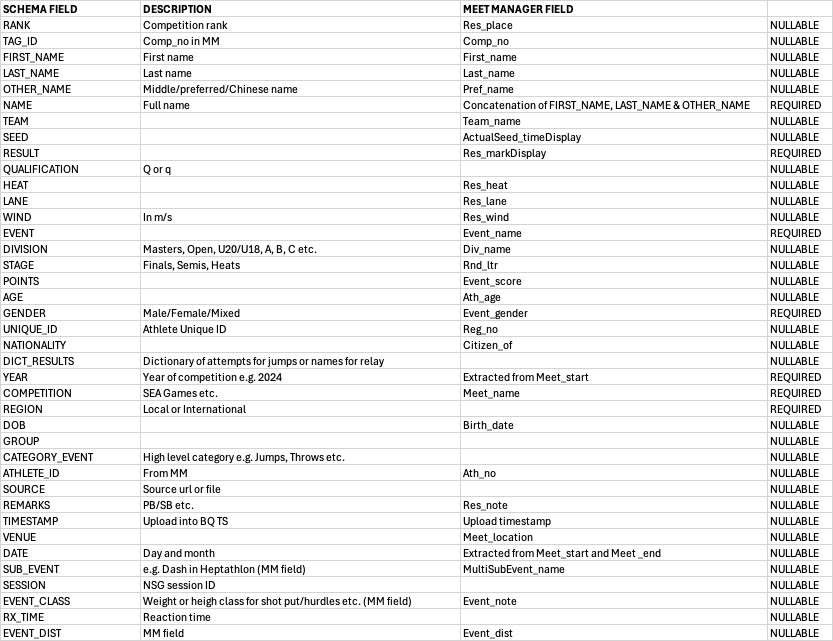

In [182]:
df.shape[1]

176

In [183]:
df.columns.get_loc('Full_Eventname')

#df.columns.get_loc('FULL_EVENTNAME')

9

In [184]:
df.columns.get_loc('Res_markDisplay')

#df.columns.get_loc('RES_MARKDISPLAY')

30

In [185]:
#df.columns.get_loc('MEET_NAME')

df.columns.get_loc('Meet_name')

170

In [186]:
df = df.astype(str)

In [187]:
df['MultiSubEvent_name']

0       
1       
2       
3       
4       
      ..
290     
291     
292     
293     
294     
Name: MultiSubEvent_name, Length: 295, dtype: object

In [188]:
df['Event_name']
#df['EVENT_NAME']

0           Dash
1           Dash
2           Dash
3           Dash
4           Dash
         ...    
290    Long Jump
291    Long Jump
292    High Jump
293    High Jump
294    High Jump
Name: Event_name, Length: 295, dtype: object

In [189]:
df['Div_name']

0       U15
1       U15
2       U15
3       U15
4       U15
       ... 
290    Open
291    Open
292    Open
293    Open
294    Open
Name: Div_name, Length: 295, dtype: object

In [190]:
df['Event_dist']
#df['EVENT_DIST']

0      100.0
1      100.0
2      100.0
3      100.0
4      100.0
       ...  
290      0.0
291      0.0
292      0.0
293      0.0
294      0.0
Name: Event_dist, Length: 295, dtype: object

In [191]:
df['Full_Eventname']
#df['FULL_EVENTNAME']

0      Girls 13-14 100 Meter Dash U15
1      Girls 13-14 100 Meter Dash U15
2      Girls 13-14 100 Meter Dash U15
3      Girls 13-14 100 Meter Dash U15
4      Girls 13-14 100 Meter Dash U15
                    ...              
290        Women 16-99 Long Jump Open
291        Women 16-99 Long Jump Open
292          Men 16-99 High Jump Open
293          Men 16-99 High Jump Open
294          Men 16-99 High Jump Open
Name: Full_Eventname, Length: 295, dtype: object

In [192]:
df['Res_note']

0      nan
1      nan
2      nan
3      nan
4      nan
      ... 
290    nan
291    nan
292    nan
293    nan
294    nan
Name: Res_note, Length: 295, dtype: object

In [193]:
df.columns

Index(['Event_numltr', 'Rnd_ltr', 'MultiSubEvent_no', 'Trk_Field', 'Ind_rel',
       'Event_gender', 'Event_dist', 'Event_code', 'Event_name',
       'Full_Eventname',
       ...
       'Div_name.1', 'Team_region', 'Reg_abbr', 'Reg_name', 'Meet_name',
       'Meet_header1', 'Meet_header2', 'Meet_location', 'Meet_start',
       'Meet_end'],
      dtype='object', length=176)

In [194]:
#df['Meet_name'] = df['Meet_name'].replace(regex=r'IVP Track & Field Championships 2024', value='IVP Track & Field Championships 2025')

In [195]:
# Use boolean masking to update full_eventnam field fo tris
# This is the only additional step for triathlon events


#df.loc[df['Event_name'] == 'Triathlon', 'Full_Eventname'] = 'Triathlon'+ ' - ' + df['Event_dist'] +' '+df['MultiSubEvent_name']
#df.loc[df['Event_name'] == 'Outdoor Pentathlon', 'Full_Eventname'] = 'Outdoor Pentathlon'+ ' - ' + df['Event_dist'] + ' '+ df['MultiSubEvent_name']
#df.loc[df['Event_name'] == 'Decathlon', 'Full_Eventname'] = 'Decathlon'+ ' - ' + df['Event_dist'] +' '+df['MultiSubEvent_name']
#df.loc[df['Event_name'] == 'Heptathlon', 'Full_Eventname'] = 'Heptathlon'+ ' - ' + df['Event_dist'] +' '+df['MultiSubEvent_name']


In [196]:
# Old schema
#df_filtered = df[['Last_name', 'First_name', 'Event_gender', 'Birth_date', 'Ath_age', 'Comp_no', 'Team_name.1','Full_Eventname', 'ActualSeed_timeDisplay','Rnd_ltr', 'Reg_no',
#                 'Res_heat', 'Res_lane', 'Res_markDisplay', 'Res_wind', 'Res_place', 'Res_note', 'Ath_no', 'Div_name', 'Relay_Ltr', 'RelayLeg1_Ath_no', 'RelayLeg1_Last_name', 'RelayLeg1_First_name',
#                 'RelayLeg2_Ath_no', 'RelayLeg2_Last_name', 'RelayLeg2_First_name', 'RelayLeg3_Ath_no', 'RelayLeg3_Last_name', 'RelayLeg3_First_name', 'RelayLeg4_Ath_no', 'RelayLeg4_Last_name', 'RelayLeg4_First_name',
#                 'RelayLeg5_Ath_no', 'RelayLeg5_Last_name', 'RelayLeg5_First_name', 'RelayLeg6_Ath_no', 'RelayLeg6_Last_name', 'RelayLeg6_First_name', 'RelayLeg7_Ath_no', 'RelayLeg7_Last_name', 'RelayLeg7_First_name',
#                 'RelayLeg8_Ath_no', 'RelayLeg8_Last_name', 'RelayLeg8_First_name', 'Meet_name', 'Meet_start']].copy()


# New schema

df_filtered = df[['Last_name', 'First_name', 'Pref_name', 'Citizen_of', 'Event_gender', 'Birth_date', 'Ath_age', 'Comp_no', 'Team_name.1','Event_name', 'ActualSeed_timeDisplay','Rnd_ltr', 'Reg_no',
                 'Res_heat', 'Res_markDisplay', 'Res_wind', 'Res_place', 'Res_lane', 'Res_note', 'Ath_no', 'Div_name', 'Relay_Ltr', 'RelayLeg1_Ath_no', 'RelayLeg1_Last_name', 'RelayLeg1_First_name',
                 'RelayLeg2_Ath_no', 'RelayLeg2_Last_name', 'RelayLeg2_First_name', 'RelayLeg3_Ath_no', 'RelayLeg3_Last_name', 'RelayLeg3_First_name', 'RelayLeg4_Ath_no', 'RelayLeg4_Last_name', 'RelayLeg4_First_name',
                 'RelayLeg5_Ath_no', 'RelayLeg5_Last_name', 'RelayLeg5_First_name', 'RelayLeg6_Ath_no', 'RelayLeg6_Last_name', 'RelayLeg6_First_name', 'RelayLeg7_Ath_no', 'RelayLeg7_Last_name', 'RelayLeg7_First_name',
                 'RelayLeg8_Ath_no', 'RelayLeg8_Last_name', 'RelayLeg8_First_name', 'Meet_name', 'Meet_start', 'Meet_end', 'MultiSubEvent_name', 'Event_note', 'Event_dist', 'Event_score', 'Meet_location']].copy()

#df_filtered = df[['LAST_NAME', 'FIRST_NAME', 'Pref_name', 'Citizen_of', 'EVENT_GENDER', 'BIRTH_DATE', 'ATH_AGE', 'COMP_NO', 'TEAM_NAME.1','EVENT_NAME', 'ACTUALSEED_TIMEDISPLAY','Rnd_ltr', 'Reg_no',
#                 'Res_heat', 'RES_MARKDISPLAY', 'RES_WIND', 'RES_PLACE', 'Res_lane', 'Res_note', 'Ath_no', 'Div_name', 'Relay_Ltr', 'RelayLeg1_Ath_no', 'RelayLeg1_Last_name', 'RelayLeg1_First_name',
#                 'RelayLeg2_Ath_no', 'RelayLeg2_Last_name', 'RelayLeg2_First_name', 'RelayLeg3_Ath_no', 'RelayLeg3_Last_name', 'RelayLeg3_First_name', 'RelayLeg4_Ath_no', 'RelayLeg4_Last_name', 'RelayLeg4_First_name',
#                 'RelayLeg5_Ath_no', 'RelayLeg5_Last_name', 'RelayLeg5_First_name', 'RelayLeg6_Ath_no', 'RelayLeg6_Last_name', 'RelayLeg6_First_name', 'RelayLeg7_Ath_no', 'RelayLeg7_Last_name', 'RelayLeg7_First_name',
#                 'RelayLeg8_Ath_no', 'RelayLeg8_Last_name', 'RelayLeg8_First_name', 'Meet_name', 'Meet_start', 'Meet_end', 'MultiSubEvent_name', 'Event_note', 'EVENT_DIST', 'Event_score', 'Meet_location']].copy()


In [197]:
df_filtered

,Last_name,First_name,Pref_name,Citizen_of,Event_gender,Birth_date,Ath_age,Comp_no,Team_name.1,Event_name,...,RelayLeg8_Last_name,RelayLeg8_First_name,Meet_name,Meet_start,Meet_end,MultiSubEvent_name,Event_note,Event_dist,Event_score,Meet_location
0,Kiat,Mira Verena,nan,nan,F,2012-01-01 00:00:00.000,13,5111,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
1,Kiat,Mira Verena,nan,nan,F,2012-01-01 00:00:00.000,13,5111,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
2,Lim,En Ting Kayna,nan,nan,F,2012-01-01 00:00:00.000,13,5113,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
3,Koh,Egaphya Ning Xuan,nan,nan,F,2012-01-01 00:00:00.000,13,5112,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
4,Koh,Egaphya Ning Xuan,nan,nan,F,2012-01-01 00:00:00.000,13,5112,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Vaz,Luisa Marie,nan,nan,F,2008-01-01 00:00:00.000,17,5270,Singapore Sports School,Long Jump,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School
291,Ng,Lin Jie,nan,,F,2006-01-01 00:00:00.000,19,5094,Club ZOOM,Long Jump,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School
292,Tam,Joash,nan,nan,M,2007-01-01 00:00:00.000,18,5330,Victoria Junior College,High Jump,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School
293,Kumar,Viresh,nan,nan,M,2007-01-01 00:00:00.000,18,5324,Victoria Junior College,High Jump,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School


In [198]:
df_filtered.drop_duplicates(inplace=True)    


In [199]:
df_filtered

,Last_name,First_name,Pref_name,Citizen_of,Event_gender,Birth_date,Ath_age,Comp_no,Team_name.1,Event_name,...,RelayLeg8_Last_name,RelayLeg8_First_name,Meet_name,Meet_start,Meet_end,MultiSubEvent_name,Event_note,Event_dist,Event_score,Meet_location
0,Kiat,Mira Verena,nan,nan,F,2012-01-01 00:00:00.000,13,5111,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
1,Kiat,Mira Verena,nan,nan,F,2012-01-01 00:00:00.000,13,5111,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
2,Lim,En Ting Kayna,nan,nan,F,2012-01-01 00:00:00.000,13,5113,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
3,Koh,Egaphya Ning Xuan,nan,nan,F,2012-01-01 00:00:00.000,13,5112,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
4,Koh,Egaphya Ning Xuan,nan,nan,F,2012-01-01 00:00:00.000,13,5112,Dunman High School,Dash,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Vaz,Luisa Marie,nan,nan,F,2008-01-01 00:00:00.000,17,5270,Singapore Sports School,Long Jump,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School
291,Ng,Lin Jie,nan,,F,2006-01-01 00:00:00.000,19,5094,Club ZOOM,Long Jump,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School
292,Tam,Joash,nan,nan,M,2007-01-01 00:00:00.000,18,5330,Victoria Junior College,High Jump,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School
293,Kumar,Viresh,nan,nan,M,2007-01-01 00:00:00.000,18,5324,Victoria Junior College,High Jump,...,,,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School


In [200]:
#df_filtered.to_csv('TESTING.csv', sep=',', encoding='utf-8-sig', index=False)

In [201]:
#df_filtered['Name']= df_filtered['LAST_NAME'] + ', '+ df_filtered['FIRST_NAME']

df_filtered['Name']= df_filtered['Last_name'] + ', '+ df_filtered['First_name']

#df_filtered.drop(['Last_name', 'First_name'], axis=1, inplace=True)



In [202]:
df_filtered['Name']

0           Kiat, Mira Verena
1           Kiat, Mira Verena
2          Lim, En Ting Kayna
3      Koh, Egaphya Ning Xuan
4      Koh, Egaphya Ning Xuan
                ...          
290          Vaz, Luisa Marie
291               Ng, Lin Jie
292                Tam, Joash
293             Kumar, Viresh
294             Heng, Brandon
Name: Name, Length: 295, dtype: object

In [203]:
df_filtered['Relay1_Leg_Name']= df_filtered['RelayLeg1_Last_name'] + ', '+ df_filtered['RelayLeg1_First_name']
df_filtered['Relay2_Leg_Name']= df_filtered['RelayLeg2_Last_name'] + ', '+ df_filtered['RelayLeg2_First_name']
df_filtered['Relay3_Leg_Name']= df_filtered['RelayLeg3_Last_name'] + ', '+ df_filtered['RelayLeg3_First_name']
df_filtered['Relay4_Leg_Name']= df_filtered['RelayLeg4_Last_name'] + ', '+ df_filtered['RelayLeg4_First_name']
df_filtered['Relay5_Leg_Name']= df_filtered['RelayLeg5_Last_name'] + ', '+ df_filtered['RelayLeg5_First_name']
df_filtered['Relay6_Leg_Name']= df_filtered['RelayLeg6_Last_name'] + ', '+ df_filtered['RelayLeg6_First_name']
df_filtered['Relay7_Leg_Name']= df_filtered['RelayLeg7_Last_name'] + ', '+ df_filtered['RelayLeg7_First_name']
df_filtered['Relay8_Leg_Name']= df_filtered['RelayLeg8_Last_name'] + ', '+ df_filtered['RelayLeg8_First_name']

df_filtered.drop(['RelayLeg1_Last_name', 'RelayLeg1_First_name', 'RelayLeg2_Last_name', 'RelayLeg2_First_name',
                 'RelayLeg3_Last_name', 'RelayLeg3_First_name', 'RelayLeg4_Last_name', 'RelayLeg4_First_name',
                 'RelayLeg5_Last_name', 'RelayLeg5_First_name', 'RelayLeg6_Last_name', 'RelayLeg6_First_name',
                 'RelayLeg7_Last_name', 'RelayLeg7_First_name', 'RelayLeg8_Last_name', 'RelayLeg8_First_name'], axis=1, inplace=True)

df_filtered.drop_duplicates(inplace=True)

In [204]:
df_filtered

,Last_name,First_name,Pref_name,Citizen_of,Event_gender,Birth_date,Ath_age,Comp_no,Team_name.1,Event_name,...,Meet_location,Name,Relay1_Leg_Name,Relay2_Leg_Name,Relay3_Leg_Name,Relay4_Leg_Name,Relay5_Leg_Name,Relay6_Leg_Name,Relay7_Leg_Name,Relay8_Leg_Name
0,Kiat,Mira Verena,nan,nan,F,2012-01-01 00:00:00.000,13,5111,Dunman High School,Dash,...,Singapore Sports School,"Kiat, Mira Verena",",",",",",",",",",",",",",",","
1,Kiat,Mira Verena,nan,nan,F,2012-01-01 00:00:00.000,13,5111,Dunman High School,Dash,...,Singapore Sports School,"Kiat, Mira Verena",",",",",",",",",",",",",",",","
2,Lim,En Ting Kayna,nan,nan,F,2012-01-01 00:00:00.000,13,5113,Dunman High School,Dash,...,Singapore Sports School,"Lim, En Ting Kayna",",",",",",",",",",",",",",",","
3,Koh,Egaphya Ning Xuan,nan,nan,F,2012-01-01 00:00:00.000,13,5112,Dunman High School,Dash,...,Singapore Sports School,"Koh, Egaphya Ning Xuan",",",",",",",",",",",",",",",","
4,Koh,Egaphya Ning Xuan,nan,nan,F,2012-01-01 00:00:00.000,13,5112,Dunman High School,Dash,...,Singapore Sports School,"Koh, Egaphya Ning Xuan",",",",",",",",",",",",",",",","
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Vaz,Luisa Marie,nan,nan,F,2008-01-01 00:00:00.000,17,5270,Singapore Sports School,Long Jump,...,Singapore Sports School,"Vaz, Luisa Marie",",",",",",",",",",",",",",",","
291,Ng,Lin Jie,nan,,F,2006-01-01 00:00:00.000,19,5094,Club ZOOM,Long Jump,...,Singapore Sports School,"Ng, Lin Jie",",",",",",",",",",",",",",",","
292,Tam,Joash,nan,nan,M,2007-01-01 00:00:00.000,18,5330,Victoria Junior College,High Jump,...,Singapore Sports School,"Tam, Joash",",",",",",",",",",",",",",",","
293,Kumar,Viresh,nan,nan,M,2007-01-01 00:00:00.000,18,5324,Victoria Junior College,High Jump,...,Singapore Sports School,"Kumar, Viresh",",",",",",",",",",",",",",",","


In [205]:
df_filtered.reset_index(inplace = True, drop = True)  # reset index after dropping duplicates


In [206]:
df_filtered['Name']

0           Kiat, Mira Verena
1           Kiat, Mira Verena
2          Lim, En Ting Kayna
3      Koh, Egaphya Ning Xuan
4      Koh, Egaphya Ning Xuan
                ...          
290          Vaz, Luisa Marie
291               Ng, Lin Jie
292                Tam, Joash
293             Kumar, Viresh
294             Heng, Brandon
Name: Name, Length: 295, dtype: object

In [207]:
# create dict for relay names

for i in range(len(df_filtered)):
    
    list_no=[]
    list_names=[]
    
    if 'Relay' in df_filtered.loc[i, 'Event_name']:
 #   if 'Relay' in df_filtered.loc[i, 'EVENT_NAME']:
 
                
        list_no.append(df_filtered.loc[i, 'RelayLeg1_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg2_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg3_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg4_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg5_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg6_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg7_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg8_Ath_no'])
        
        
        list_names.append(df_filtered.loc[i, 'Relay1_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay2_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay3_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay4_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay5_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay6_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay7_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay8_Leg_Name'])
        
        
        list_no = [i for i in list_no if i != 0]
        
        list_names = [i for i in list_names if i != ' ,  ']   
                
        res = {}
        for key in list_no:
            for value in list_names:
                res[key] = value
                list_names.remove(value)
                
                break
                
        print(res)
        print(df_filtered.loc[i, 'Name'])
        
        
        df_filtered.at[i, 'Name'] = res  # must use .at for dict and [res] because of adding Res_lane
        
     #   df.replace({"Courses": dict})
        
     #   df_filtered.loc[i, 'Name'] = df_filtered.loc[i, 'Name'].replace('', res)

        
        
        

        
                           
                



In [208]:
df_filtered.drop(['Relay_Ltr', 'RelayLeg1_Ath_no', 'RelayLeg2_Ath_no', 'RelayLeg3_Ath_no', 'RelayLeg4_Ath_no', 
                  'RelayLeg5_Ath_no', 'RelayLeg6_Ath_no', 'RelayLeg7_Ath_no', 'RelayLeg8_Ath_no', 'Relay1_Leg_Name',
                  'Relay2_Leg_Name', 'Relay3_Leg_Name', 'Relay4_Leg_Name', 'Relay5_Leg_Name', 'Relay6_Leg_Name',
                  'Relay7_Leg_Name', 'Relay8_Leg_Name'], axis=1, inplace=True)


In [209]:
df_filtered['Name']=df_filtered['Name'].astype(str) # convert dict to str so duplicates can be dropped


In [210]:
df_filtered

,Last_name,First_name,Pref_name,Citizen_of,Event_gender,Birth_date,Ath_age,Comp_no,Team_name.1,Event_name,...,Div_name,Meet_name,Meet_start,Meet_end,MultiSubEvent_name,Event_note,Event_dist,Event_score,Meet_location,Name
0,Kiat,Mira Verena,nan,nan,F,2012-01-01 00:00:00.000,13,5111,Dunman High School,Dash,...,U15,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School,"Kiat, Mira Verena"
1,Kiat,Mira Verena,nan,nan,F,2012-01-01 00:00:00.000,13,5111,Dunman High School,Dash,...,U15,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School,"Kiat, Mira Verena"
2,Lim,En Ting Kayna,nan,nan,F,2012-01-01 00:00:00.000,13,5113,Dunman High School,Dash,...,U15,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School,"Lim, En Ting Kayna"
3,Koh,Egaphya Ning Xuan,nan,nan,F,2012-01-01 00:00:00.000,13,5112,Dunman High School,Dash,...,U15,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School,"Koh, Egaphya Ning Xuan"
4,Koh,Egaphya Ning Xuan,nan,nan,F,2012-01-01 00:00:00.000,13,5112,Dunman High School,Dash,...,U15,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,100.0,0.0,Singapore Sports School,"Koh, Egaphya Ning Xuan"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Vaz,Luisa Marie,nan,nan,F,2008-01-01 00:00:00.000,17,5270,Singapore Sports School,Long Jump,...,Open,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School,"Vaz, Luisa Marie"
291,Ng,Lin Jie,nan,,F,2006-01-01 00:00:00.000,19,5094,Club ZOOM,Long Jump,...,Open,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School,"Ng, Lin Jie"
292,Tam,Joash,nan,nan,M,2007-01-01 00:00:00.000,18,5330,Victoria Junior College,High Jump,...,Open,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School,"Tam, Joash"
293,Kumar,Viresh,nan,nan,M,2007-01-01 00:00:00.000,18,5324,Victoria Junior College,High Jump,...,Open,SSP Invitational U15 and U18 2025,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000,,,0.0,0.0,Singapore Sports School,"Kumar, Viresh"


In [211]:
# Extract date & year

df_filtered['Meet_start'] = pd.to_datetime(df_filtered['Meet_start'], format='mixed')
df_filtered['Meet_end'] = pd.to_datetime(df_filtered['Meet_end'], format='mixed')

df_filtered['YEAR'] = df_filtered['Meet_start'].dt.year

df_filtered['DATE'] = df_filtered['Meet_end']

#df_filtered['DATE'] = str(df_filtered['Meet_start'].dt.month[1]) + '/' + str(df_filtered['Meet_start'].dt.day[1]) + ' to ' + str(df_filtered['Meet_end'].dt.month[1]) + '/' + str(df_filtered['Meet_end'].dt.day[1]) 
#df_filtered.drop('Meet_start', axis=1, inplace=True)

In [159]:
df_filtered['DATE']

0     2025-05-31
1     2025-05-31
2     2025-05-31
3     2025-05-31
4     2025-05-31
         ...    
290   2025-05-31
291   2025-05-31
292   2025-05-31
293   2025-05-31
294   2025-05-31
Name: DATE, Length: 295, dtype: datetime64[ns]

In [212]:
df_filtered['DATE'] = df_filtered['DATE'].dt.tz_localize('UTC')

In [213]:
#df_filtered['DATE'] = pd.to_datetime(df_filtered['DATE'], dayfirst=True, utc=True)

In [214]:
df_filtered['DATE']

0     2025-05-31 00:00:00+00:00
1     2025-05-31 00:00:00+00:00
2     2025-05-31 00:00:00+00:00
3     2025-05-31 00:00:00+00:00
4     2025-05-31 00:00:00+00:00
                 ...           
290   2025-05-31 00:00:00+00:00
291   2025-05-31 00:00:00+00:00
292   2025-05-31 00:00:00+00:00
293   2025-05-31 00:00:00+00:00
294   2025-05-31 00:00:00+00:00
Name: DATE, Length: 295, dtype: datetime64[ns, UTC]

In [215]:
'''
df_filtered['NOW'] = datetime.datetime.now()

timezone = pytz.timezone('UTC')

df_filtered['NOW'] = datetime.datetime.now().replace(tzinfo=timezone)

df_filtered['delta_time'] = df_filtered['NOW'] - df_filtered['DATE']
'''

"\ndf_filtered['NOW'] = datetime.datetime.now()\n\ntimezone = pytz.timezone('UTC')\n\ndf_filtered['NOW'] = datetime.datetime.now().replace(tzinfo=timezone)\n\ndf_filtered['delta_time'] = df_filtered['NOW'] - df_filtered['DATE']\n"

In [216]:
df_filtered.columns

Index(['Last_name', 'First_name', 'Pref_name', 'Citizen_of', 'Event_gender',
       'Birth_date', 'Ath_age', 'Comp_no', 'Team_name.1', 'Event_name',
       'ActualSeed_timeDisplay', 'Rnd_ltr', 'Reg_no', 'Res_heat',
       'Res_markDisplay', 'Res_wind', 'Res_place', 'Res_lane', 'Res_note',
       'Ath_no', 'Div_name', 'Meet_name', 'Meet_start', 'Meet_end',
       'MultiSubEvent_name', 'Event_note', 'Event_dist', 'Event_score',
       'Meet_location', 'Name', 'YEAR', 'DATE'],
      dtype='object')

In [217]:
df_filtered.drop(['Meet_start', 'Meet_end'], axis=1, inplace=True)


In [218]:
df_filtered.to_csv('column_check.csv', sep=',', encoding='utf-8-sig', index=False)

In [219]:
df_filtered.columns

Index(['Last_name', 'First_name', 'Pref_name', 'Citizen_of', 'Event_gender',
       'Birth_date', 'Ath_age', 'Comp_no', 'Team_name.1', 'Event_name',
       'ActualSeed_timeDisplay', 'Rnd_ltr', 'Reg_no', 'Res_heat',
       'Res_markDisplay', 'Res_wind', 'Res_place', 'Res_lane', 'Res_note',
       'Ath_no', 'Div_name', 'Meet_name', 'MultiSubEvent_name', 'Event_note',
       'Event_dist', 'Event_score', 'Meet_location', 'Name', 'YEAR', 'DATE'],
      dtype='object')

In [220]:
# New schema

# Rename columns. Event Class = 500g for javelin etc (mapped to Event_note). SUB_EVENT=dash under decathlon
# Need to add: Last_name, First_name, Pref_name


df_filtered.columns = ['LAST_NAME', 'FIRST_NAME', 'OTHER_NAME', 'NATIONALITY', 'GENDER', 'DOB', 'AGE', 'TAG_ID', 'TEAM', 'EVENT', 'SEED', 'STAGE', 'UNIQUE_ID', 'HEAT', 'RESULT', 'WIND', 'RANK', 'LANE', 'REMARKS', 'ATHLETE_ID', 'DIVISION', 'COMPETITION', 'SUB_EVENT', 'EVENT_CLASS', 'DISTANCE', 'POINTS', 'VENUE', 'NAME', 'YEAR', 'DATE']

df_filtered['QUALIFICATION']=''
#df_filtered['UNIQUE_ID']=''
df_filtered['DICT_RESULTS']=''
#df_filtered['COMPETITION']='84th Singapore Open'
df_filtered['REGION']='Local'
df_filtered['GROUP']=''
df_filtered['CATEGORY_EVENT']=''
df_filtered['SOURCE']='Meet Manager'
df_filtered['TIMESTAMP']=''
df_filtered['SESSION']=''
df_filtered['HOST_CITY']='Singapore'
df_filtered['RX_TIME']=''


# Map miscellaneous fields to final formats                            
                            
mask = df_filtered['STAGE'].str.contains(r'F', na=True)
df_filtered.loc[mask, 'STAGE'] = 'Final'

mask = df_filtered['STAGE'].str.contains(r'P', na=True)
df_filtered.loc[mask, 'STAGE'] = 'Preliminaries'
                                    
mask = df_filtered['GENDER'].isin(['F'])
df_filtered.loc[mask, 'GENDER'] = 'Female'

mask = df_filtered['GENDER'].isin(['M'])
df_filtered.loc[mask, 'GENDER'] = 'Male'

mask = df_filtered['GENDER'].isin(['X'])
df_filtered.loc[mask, 'GENDER'] = 'Mixed'


# Map general event category 

df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'60', na=True))&(df_filtered['EVENT'].str.contains(r'Dash', na=True))), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'80', na=True))&(df_filtered['EVENT'].str.contains(r'Dash', na=True))), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'100', na=True))&(df_filtered['EVENT'].str.contains(r'Dash', na=True))), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'200', na=True))&(df_filtered['EVENT'].str.contains(r'Dash', na=True))), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'400', na=True))&(df_filtered['EVENT'].str.contains(r'Dash', na=True))), 'CATEGORY_EVENT'] = 'Sprint'


df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'800', na=True))&(df_filtered['EVENT'].str.contains(r'Run', na=True))), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'1500', na=True))&(df_filtered['EVENT'].str.contains(r'Run', na=True))), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'2000', na=True))&(df_filtered['EVENT'].str.contains(r'Run', na=True))), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Mile', na=True), 'CATEGORY_EVENT'] = 'Mid'


df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'3000', na=True))&(df_filtered['EVENT'].str.contains(r'Run', na=True))), 'CATEGORY_EVENT'] = 'Long'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'5000', na=True))&(df_filtered['EVENT'].str.contains(r'Run', na=True))), 'CATEGORY_EVENT'] = 'Long'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'10000', na=True))&(df_filtered['EVENT'].str.contains(r'Run', na=True))), 'CATEGORY_EVENT'] = 'Long'


df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'100', na=True))&(df_filtered['EVENT'].str.contains(r'Hurdes', na=True))), 'CATEGORY_EVENT'] = 'Hurdles'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'110', na=True))&(df_filtered['EVENT'].str.contains(r'Hurdes', na=True))), 'CATEGORY_EVENT'] = 'Hurdles'
df_filtered.loc[((df_filtered['DISTANCE'].str.contains(r'400', na=True))&(df_filtered['EVENT'].str.contains(r'Hurdles', na=True))), 'CATEGORY_EVENT'] = 'Hurdles'


# Override values

df_filtered.loc[df_filtered['EVENT'].str.contains(r'Discus', na=True), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Javelin', na=True), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Shot', na=True), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Vault', na=True), 'CATEGORY_EVENT'] = 'Jump'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Throw', na=True), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Jump', na=True), 'CATEGORY_EVENT'] = 'Jump'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Relay', na=True), 'CATEGORY_EVENT'] = 'Relay'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Steeple', na=True), 'CATEGORY_EVENT'] = 'Steeple'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Walk', na=True), 'CATEGORY_EVENT'] = 'Walk'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Hurdles', na=True), 'CATEGORY_EVENT'] = 'Hurdles'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Pentathlon', na=True), 'CATEGORY_EVENT'] = 'Pentathlon'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Triathlon', na=True), 'CATEGORY_EVENT'] = 'Triathlon'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Decathlon', na=True), 'CATEGORY_EVENT'] = 'Decathlon'


# Rename conventions e.g. 100 Meters becomes 100m to be consistent with rest of dataset  

#df_filtered.loc[df_filtered['EVENT'].str.contains(r'100.0 Dash', na=True), 'EVENT'] = '100m'

    

df_filtered = df_filtered.reindex(columns= ['FIRST_NAME', 'LAST_NAME', 'OTHER_NAME', 'NAME', 'RANK', 'TAG_ID', 'TEAM', 'SEED', 'RESULT', 'QUALIFICATION',
                                        'HEAT', 'LANE', 'WIND', 'EVENT', 'DIVISION', 'STAGE', 'POINTS', 'AGE', 'GENDER', 'UNIQUE_ID', 'NATIONALITY',
                                        'DICT_RESULTS', 'YEAR', 'DATE', 'COMPETITION', 'REGION', 'DOB', 'GROUP', 'CATEGORY_EVENT', 'ATHLETE_ID',
                                        'SOURCE', 'REMARKS', 'TIMESTAMP', 'VENUE', 'SUB_EVENT', 'SESSION', 'EVENT_CLASS', 'DISTANCE', 'HOST_CITY', 'RX_TIME'])




In [221]:
df_filtered

,FIRST_NAME,LAST_NAME,OTHER_NAME,NAME,RANK,TAG_ID,TEAM,SEED,RESULT,QUALIFICATION,...,SOURCE,REMARKS,TIMESTAMP,VENUE,SUB_EVENT,SESSION,EVENT_CLASS,DISTANCE,HOST_CITY,RX_TIME
0,Mira Verena,Kiat,nan,"Kiat, Mira Verena",7,5111,Dunman High School,,14.31,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
1,Mira Verena,Kiat,nan,"Kiat, Mira Verena",5,5111,Dunman High School,,14.23,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
2,En Ting Kayna,Lim,nan,"Lim, En Ting Kayna",11,5113,Dunman High School,15.14,15.26,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
3,Egaphya Ning Xuan,Koh,nan,"Koh, Egaphya Ning Xuan",3,5112,Dunman High School,14.10,13.93,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
4,Egaphya Ning Xuan,Koh,nan,"Koh, Egaphya Ning Xuan",3,5112,Dunman High School,14.10,13.85,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Luisa Marie,Vaz,nan,"Vaz, Luisa Marie",5,5270,Singapore Sports School,4.26m,4.42m,,...,Meet Manager,nan,,Singapore Sports School,,,,0.0,Singapore,
291,Lin Jie,Ng,nan,"Ng, Lin Jie",3,5094,Club ZOOM,4.80m,4.68m,,...,Meet Manager,nan,,Singapore Sports School,,,,0.0,Singapore,
292,Joash,Tam,nan,"Tam, Joash",3,5330,Victoria Junior College,1.96m,1.90m,,...,Meet Manager,nan,,Singapore Sports School,,,,0.0,Singapore,
293,Viresh,Kumar,nan,"Kumar, Viresh",2,5324,Victoria Junior College,2.00m,1.94m,,...,Meet Manager,nan,,Singapore Sports School,,,,0.0,Singapore,


In [222]:
df_filtered['DOB']=df_filtered.DOB.str.rstrip('00:00:00.000')


In [223]:
df_filtered

,FIRST_NAME,LAST_NAME,OTHER_NAME,NAME,RANK,TAG_ID,TEAM,SEED,RESULT,QUALIFICATION,...,SOURCE,REMARKS,TIMESTAMP,VENUE,SUB_EVENT,SESSION,EVENT_CLASS,DISTANCE,HOST_CITY,RX_TIME
0,Mira Verena,Kiat,nan,"Kiat, Mira Verena",7,5111,Dunman High School,,14.31,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
1,Mira Verena,Kiat,nan,"Kiat, Mira Verena",5,5111,Dunman High School,,14.23,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
2,En Ting Kayna,Lim,nan,"Lim, En Ting Kayna",11,5113,Dunman High School,15.14,15.26,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
3,Egaphya Ning Xuan,Koh,nan,"Koh, Egaphya Ning Xuan",3,5112,Dunman High School,14.10,13.93,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
4,Egaphya Ning Xuan,Koh,nan,"Koh, Egaphya Ning Xuan",3,5112,Dunman High School,14.10,13.85,,...,Meet Manager,nan,,Singapore Sports School,,,,100.0,Singapore,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Luisa Marie,Vaz,nan,"Vaz, Luisa Marie",5,5270,Singapore Sports School,4.26m,4.42m,,...,Meet Manager,nan,,Singapore Sports School,,,,0.0,Singapore,
291,Lin Jie,Ng,nan,"Ng, Lin Jie",3,5094,Club ZOOM,4.80m,4.68m,,...,Meet Manager,nan,,Singapore Sports School,,,,0.0,Singapore,
292,Joash,Tam,nan,"Tam, Joash",3,5330,Victoria Junior College,1.96m,1.90m,,...,Meet Manager,nan,,Singapore Sports School,,,,0.0,Singapore,
293,Viresh,Kumar,nan,"Kumar, Viresh",2,5324,Victoria Junior College,2.00m,1.94m,,...,Meet Manager,nan,,Singapore Sports School,,,,0.0,Singapore,


In [224]:
df_filtered['POINTS']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
290    0.0
291    0.0
292    0.0
293    0.0
294    0.0
Name: POINTS, Length: 295, dtype: object

In [225]:
df_filtered['RESULT']

0      14.31
1      14.23
2      15.26
3      13.93
4      13.85
       ...  
290    4.42m
291    4.68m
292    1.90m
293    1.94m
294    1.96m
Name: RESULT, Length: 295, dtype: object

In [226]:
# Remove special characters
    
for col in df_filtered.columns:
    df_filtered[col] = df_filtered[col].astype(str)
    df_filtered[col] = df_filtered[col].str.replace('\xa0', ' ', regex=True)
    df_filtered[col] = df_filtered[col].str.replace('[\x00-\x1f\x7f-\x9f]', '', regex=True)
    df_filtered[col] = df_filtered[col].str.replace('\r', ' ', regex=True)
    df_filtered[col] = df_filtered[col].str.replace('\n', ' ', regex=True)
    df_filtered[col] = df_filtered[col].str.strip()



In [227]:
# Set timestamp

from datetime import datetime

ct = datetime.now()

df_filtered.loc[:,'TIMESTAMP'] = ct


In [234]:
df_filtered['TIMESTAMP'] = pd.to_datetime(df_filtered['TIMESTAMP'], format='mixed', dayfirst=False, utc=False)

In [244]:
df_filtered['TIMESTAMP'] = df_filtered['TIMESTAMP'].astype(str)

In [245]:
df_filtered['TIMESTAMP']

0      2025-07-10 17:26:43.048429+00:00
1      2025-07-10 17:26:43.048429+00:00
2      2025-07-10 17:26:43.048429+00:00
3      2025-07-10 17:26:43.048429+00:00
4      2025-07-10 17:26:43.048429+00:00
                     ...               
290    2025-07-10 17:26:43.048429+00:00
291    2025-07-10 17:26:43.048429+00:00
292    2025-07-10 17:26:43.048429+00:00
293    2025-07-10 17:26:43.048429+00:00
294    2025-07-10 17:26:43.048429+00:00
Name: TIMESTAMP, Length: 295, dtype: object

In [236]:
df_filtered['DATE']

0      2025-05-31 00:00:00+00:00
1      2025-05-31 00:00:00+00:00
2      2025-05-31 00:00:00+00:00
3      2025-05-31 00:00:00+00:00
4      2025-05-31 00:00:00+00:00
                 ...            
290    2025-05-31 00:00:00+00:00
291    2025-05-31 00:00:00+00:00
292    2025-05-31 00:00:00+00:00
293    2025-05-31 00:00:00+00:00
294    2025-05-31 00:00:00+00:00
Name: DATE, Length: 295, dtype: object

In [248]:
# Load BQ Modified Schema

modified_schema = [
            bigquery.SchemaField("FIRST_NAME", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("LAST_NAME", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("OTHER_NAME", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("NAME", "STRING", mode="REQUIRED"),
            bigquery.SchemaField("RANK", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("TAG_ID", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("TEAM", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("SEED", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("RESULT", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("QUALIFICATION", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("HEAT", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("LANE", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("WIND", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("EVENT", "STRING", mode="REQUIRED"),
            bigquery.SchemaField("DIVISION", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("STAGE", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("POINTS", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("AGE", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("GENDER", "STRING", mode="REQUIRED"),
            bigquery.SchemaField("UNIQUE_ID", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("NATIONALITY", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("DICT_RESULTS", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("YEAR", "STRING", mode="REQUIRED"),
            bigquery.SchemaField("DATE", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("COMPETITION", "STRING", mode="REQUIRED"),
            bigquery.SchemaField("REGION", "STRING", mode="REQUIRED"),
            bigquery.SchemaField("DOB", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("GROUP", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("CATEGORY_EVENT", "STRING", mode="REQUIRED"),
            bigquery.SchemaField("ATHLETE_ID", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("SOURCE", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("REMARKS", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("TIMESTAMP", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("VENUE", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("SUB_EVENT", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("SESSION", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("EVENT_CLASS", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("DISTANCE", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("HOST_CITY", "STRING", mode="NULLABLE"),
            bigquery.SchemaField("RX_TIME", "STRING", mode="NULLABLE"),
]

In [250]:
df_filtered

,FIRST_NAME,LAST_NAME,OTHER_NAME,NAME,RANK,TAG_ID,TEAM,SEED,RESULT,QUALIFICATION,...,SOURCE,REMARKS,TIMESTAMP,VENUE,SUB_EVENT,SESSION,EVENT_CLASS,DISTANCE,HOST_CITY,RX_TIME
0,Mira Verena,Kiat,nan,"Kiat, Mira Verena",7,5111,Dunman High School,,14.31,,...,Meet Manager,nan,2025-07-10 17:26:43.048429+00:00,Singapore Sports School,,,,100.0,Singapore,
1,Mira Verena,Kiat,nan,"Kiat, Mira Verena",5,5111,Dunman High School,,14.23,,...,Meet Manager,nan,2025-07-10 17:26:43.048429+00:00,Singapore Sports School,,,,100.0,Singapore,
2,En Ting Kayna,Lim,nan,"Lim, En Ting Kayna",11,5113,Dunman High School,15.14,15.26,,...,Meet Manager,nan,2025-07-10 17:26:43.048429+00:00,Singapore Sports School,,,,100.0,Singapore,
3,Egaphya Ning Xuan,Koh,nan,"Koh, Egaphya Ning Xuan",3,5112,Dunman High School,14.10,13.93,,...,Meet Manager,nan,2025-07-10 17:26:43.048429+00:00,Singapore Sports School,,,,100.0,Singapore,
4,Egaphya Ning Xuan,Koh,nan,"Koh, Egaphya Ning Xuan",3,5112,Dunman High School,14.10,13.85,,...,Meet Manager,nan,2025-07-10 17:26:43.048429+00:00,Singapore Sports School,,,,100.0,Singapore,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,Luisa Marie,Vaz,nan,"Vaz, Luisa Marie",5,5270,Singapore Sports School,4.26m,4.42m,,...,Meet Manager,nan,2025-07-10 17:26:43.048429+00:00,Singapore Sports School,,,,0.0,Singapore,
291,Lin Jie,Ng,nan,"Ng, Lin Jie",3,5094,Club ZOOM,4.80m,4.68m,,...,Meet Manager,nan,2025-07-10 17:26:43.048429+00:00,Singapore Sports School,,,,0.0,Singapore,
292,Joash,Tam,nan,"Tam, Joash",3,5330,Victoria Junior College,1.96m,1.90m,,...,Meet Manager,nan,2025-07-10 17:26:43.048429+00:00,Singapore Sports School,,,,0.0,Singapore,
293,Viresh,Kumar,nan,"Kumar, Viresh",2,5324,Victoria Junior College,2.00m,1.94m,,...,Meet Manager,nan,2025-07-10 17:26:43.048429+00:00,Singapore Sports School,,,,0.0,Singapore,


In [ ]:
# Check dataframe before uploading in BQ

gender_pattern = 'Male|Female|Mixed'
year_pattern = '20\d\d'
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df['YEAR'] = df['YEAR'].astype(str)
df['DATE'] = df['DATE'].astype(str)
df['DOB'] = df['DOB'].astype(str)
df['event_date_dt'] = pd.to_datetime(df['event_date'], format='mixed', dayfirst=False, utc=True)


for index, row in df.iterrows():
        
    assert re.search(gender_pattern, row['GENDER']) is not None   # check format of gender input
    assert row['NAME'] != None
    assert len(row['NAME'])>5
    assert row['DATE'] != None
    assert row['EVENT'] != None 
    assert row['COMPETITION'] != None 
    assert row['REGION'] != None
    assert row['DATE'] is not None
    assert row['CATEGORY_EVENT'] is not None
    assert len(row['DATE'])>3
 #   assert ((len(row['DOB'])>3) or (row['DOB'] is None))
    assert row['NATIONALITY']=='SGP'
    assert re.search(year_pattern, row['YEAR']) is not None   # check format of year
    assert not row['event_date_dt'] is pd.NaT
    
    # Check column locations before loading

    assert len(df.columns) == 42
    assert df.columns.get_loc('RESULT') == 8
    assert df.columns.get_loc('AGE') == 17
    assert df.columns.get_loc('WIND') == 12
    assert df.columns.get_loc('COMPETITION')==24
    
   

    # Set timestamp

    df.loc[:,'TIMESTAMP'] = ct


print('PASSED')

df

In [251]:
# Write and append to TEST table in BigQuery directly with schema

client = bigquery.Client()


job_config = bigquery.LoadJobConfig(
    schema=modified_schema,
    write_disposition="WRITE_APPEND",  # or WRITE_APPEND, WRITE_EMPTY
)

job = client.load_table_from_dataframe(df_filtered, 'saa-analytics.results.PRODUCTION', job_config=job_config)
job.result()  # Wait for the job to complete

LoadJob<project=saa-analytics, location=US, id=0f473fcd-0a26-4d89-986e-2809eb8b47da>

In [101]:
# Save csv file

os.chdir('/Users/veesheenyuen/Desktop/DataScience/SAA/MM/mm_files/2025/')


df_filtered.to_csv('Processed-GenericData-SSP Invitational U15 and U18 2025-31May2025-001.csv')

In [448]:
df_filtered.columns

Index(['FIRST_NAME', 'LAST_NAME', 'OTHER_NAME', 'NAME', 'RANK', 'TAG_ID',
       'TEAM', 'SEED', 'RESULT', 'QUALIFICATION', 'HEAT', 'LANE', 'WIND',
       'EVENT', 'DIVISION', 'STAGE', 'POINTS', 'AGE', 'GENDER', 'UNIQUE_ID',
       'NATIONALITY', 'DICT_RESULTS', 'YEAR', 'DATE', 'COMPETITION', 'REGION',
       'DOB', 'GROUP', 'CATEGORY_EVENT', 'ATHLETE_ID', 'SOURCE', 'REMARKS',
       'TIMESTAMP', 'VENUE', 'SUB_EVENT', 'SESSION', 'EVENT_CLASS', 'DISTANCE',
       'HOST_CITY', 'RX_TIME'],
      dtype='object')

In [348]:
### Process GenericData-84th Singapore Open Track - Field-18Apr2024-001.mdb file due to different column names

In [264]:
os.chdir('/Users/veesheenyuen/Desktop/DataScience/SAA/MM/mm_files/2024/')

df = pd.read_csv("GenericData-84th Singapore Open Track - Field-18Apr202.csv", low_memory=False)

df.shape[1]

176

In [265]:
list(df.columns)

['EVENT_NUMLTR',
 'Rnd_ltr',
 'MultiSubEvent_no',
 'TRK_FIELD',
 'Ind_rel',
 'EVENT_GENDER',
 'EVENT_DIST',
 'EVENT_CODE',
 'EVENT_NAME',
 'FULL_EVENTNAME',
 'MultiSubEvent_name',
 'low_age',
 'high_age',
 'Div_no',
 'Event_note',
 'Event_Type',
 'Entry_fee',
 'Ath_no',
 'COMP_NO',
 'LAST_NAME',
 'FIRST_NAME',
 'Reg_no',
 'Team_no',
 'TEAM_ABBR',
 'Team_lsc',
 'Relay_Ltr',
 'Event_score',
 'Res_heat',
 'Res_lane',
 'Res_stat',
 'RES_MARKDISPLAY',
 'RES_MARK',
 'RES_MEAS',
 'Res_handtime',
 'RES_WIND',
 'Res_agegradeDisplay',
 'Res_agegrade',
 'Res_percent',
 'RES_HEATPLACE',
 'RES_PLACE',
 'Res_exh',
 'Res_note',
 'RelayLeg1_Ath_no',
 'RelayLeg1_Last_name',
 'RelayLeg1_First_name',
 'RelayLeg2_Ath_no',
 'RelayLeg2_Last_name',
 'RelayLeg2_First_name',
 'RelayLeg3_Ath_no',
 'RelayLeg3_Last_name',
 'RelayLeg3_First_name',
 'RelayLeg4_Ath_no',
 'RelayLeg4_Last_name',
 'RelayLeg4_First_name',
 'RelayLeg5_Ath_no',
 'RelayLeg5_Last_name',
 'RelayLeg5_First_name',
 'RelayLeg6_Ath_no',
 'RelayL

In [25]:
df_filtered = df[['LAST_NAME', 'FIRST_NAME', 'EVENT_GENDER', 'BIRTH_DATE', 'ATH_AGE', 'COMP_NO', 'TEAM_NAME.1','FULL_EVENTNAME', 'ACTUALSEED_TIMEDISPLAY','Rnd_ltr',
                 'Res_heat', 'Res_lane', 'RES_MARKDISPLAY', 'RES_WIND', 'RES_PLACE', 'Res_note', 'Ath_no', 'Div_name', 'Relay_Ltr', 'RelayLeg1_Ath_no', 'RelayLeg1_Last_name', 'RelayLeg1_First_name',
                 'RelayLeg2_Ath_no', 'RelayLeg2_Last_name', 'RelayLeg2_First_name', 'RelayLeg3_Ath_no', 'RelayLeg3_Last_name', 'RelayLeg3_First_name', 'RelayLeg4_Ath_no', 'RelayLeg4_Last_name', 'RelayLeg4_First_name',
                 'RelayLeg5_Ath_no', 'RelayLeg5_Last_name', 'RelayLeg5_First_name', 'RelayLeg6_Ath_no', 'RelayLeg6_Last_name', 'RelayLeg6_First_name', 'RelayLeg7_Ath_no', 'RelayLeg7_Last_name', 'RelayLeg7_First_name',
                 'RelayLeg8_Ath_no', 'RelayLeg8_Last_name', 'RelayLeg8_First_name', 'Meet_name', 'Meet_start']].copy()


In [26]:
df_filtered.drop_duplicates(inplace=True)    


In [27]:
df_filtered['Name']= df_filtered['LAST_NAME'] + ', '+ df_filtered['FIRST_NAME']

df_filtered.drop(['LAST_NAME', 'FIRST_NAME'], axis=1, inplace=True)


In [28]:
df_filtered['Relay1_Leg_Name']= df_filtered['RelayLeg1_Last_name'] + ', '+ df_filtered['RelayLeg1_First_name']
df_filtered['Relay2_Leg_Name']= df_filtered['RelayLeg2_Last_name'] + ', '+ df_filtered['RelayLeg2_First_name']
df_filtered['Relay3_Leg_Name']= df_filtered['RelayLeg3_Last_name'] + ', '+ df_filtered['RelayLeg3_First_name']
df_filtered['Relay4_Leg_Name']= df_filtered['RelayLeg4_Last_name'] + ', '+ df_filtered['RelayLeg4_First_name']
df_filtered['Relay5_Leg_Name']= df_filtered['RelayLeg5_Last_name'] + ', '+ df_filtered['RelayLeg5_First_name']
df_filtered['Relay6_Leg_Name']= df_filtered['RelayLeg6_Last_name'] + ', '+ df_filtered['RelayLeg6_First_name']
df_filtered['Relay7_Leg_Name']= df_filtered['RelayLeg7_Last_name'] + ', '+ df_filtered['RelayLeg7_First_name']
df_filtered['Relay8_Leg_Name']= df_filtered['RelayLeg8_Last_name'] + ', '+ df_filtered['RelayLeg8_First_name']

df_filtered.drop(['RelayLeg1_Last_name', 'RelayLeg1_First_name', 'RelayLeg2_Last_name', 'RelayLeg2_First_name',
                 'RelayLeg3_Last_name', 'RelayLeg3_First_name', 'RelayLeg4_Last_name', 'RelayLeg4_First_name',
                 'RelayLeg5_Last_name', 'RelayLeg5_First_name', 'RelayLeg6_Last_name', 'RelayLeg6_First_name',
                 'RelayLeg7_Last_name', 'RelayLeg7_First_name', 'RelayLeg8_Last_name', 'RelayLeg8_First_name'], axis=1, inplace=True)


In [29]:
df_filtered.reset_index(inplace = True, drop = True)  # reset index after dropping duplicates


In [30]:
# create dict for relay names

for i in range(len(df_filtered)):
    
    list_no=[]
    list_names=[]
    
    if 'Relay' in df_filtered.loc[i, 'FULL_EVENTNAME']:
                
        list_no.append(df_filtered.loc[i, 'RelayLeg1_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg2_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg3_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg4_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg5_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg6_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg7_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg8_Ath_no'])
        
        
        list_names.append(df_filtered.loc[i, 'Relay1_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay2_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay3_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay4_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay5_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay6_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay7_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay8_Leg_Name'])
        
        
        list_no = [i for i in list_no if i != 0]
        
        list_names = [i for i in list_names if i != ' ,  ']   
                
        res = {}
        for key in list_no:
            for value in list_names:
                res[key] = value
                list_names.remove(value)
                
                break
        
        df_filtered.at[i, 'Name'] = res  # must use .at for dict
                           
                



In [31]:
df_filtered.drop(['Relay_Ltr', 'RelayLeg1_Ath_no', 'RelayLeg2_Ath_no', 'RelayLeg3_Ath_no', 'RelayLeg4_Ath_no', 
                  'RelayLeg5_Ath_no', 'RelayLeg6_Ath_no', 'RelayLeg7_Ath_no', 'RelayLeg8_Ath_no', 'Relay1_Leg_Name',
                  'Relay2_Leg_Name', 'Relay3_Leg_Name', 'Relay4_Leg_Name', 'Relay5_Leg_Name', 'Relay6_Leg_Name',
                  'Relay7_Leg_Name', 'Relay8_Leg_Name'], axis=1, inplace=True)


In [32]:
df_filtered['Name']=df_filtered['Name'].astype(str) # convert dict to str so duplicates can be dropped


In [33]:
# Extract date & year

df_filtered['Meet_start'] = pd.to_datetime(df_filtered['Meet_start'])

df_filtered['DATE'] = df_filtered['Meet_start'].dt.year

df_filtered.drop('Meet_start', axis=1, inplace=True)

In [34]:
df_filtered.columns = ['GENDER', 'DOB', 'AGE', 'TAG_ID', 'TEAM', 'EVENT', 'SEED', 'STAGE', 'HEAT', 'LANE', 'RESULT',
                      'WIND', 'RANK', 'REMARKS', 'ATHLETE_ID', 'DIVISION', 'COMPETITION', 'NAME', 'DATE']

df_filtered['QUALIFICATION']=''
df_filtered['POINTS']=''
df_filtered['UNIQUE_ID']=''
df_filtered['COUNTRY']=''
df_filtered['DICT_RESULTS']=''
#df_filtered['COMPETITION']='84th Singapore Open'
df_filtered['REGION']='Local'
df_filtered['GROUP']=''
df_filtered['CATEGORY_EVENT']=''
df_filtered['SOURCE']='Meet Manager'
df_filtered['TIMESTAMP']=''
df_filtered['FREE_FIELD']=''
df_filtered['FREE_FIELD2']=''
df_filtered['FREE_FIELD3']=''

# Map miscellaneous fields to final formats                            
                            
mask = df_filtered['STAGE'].str.contains(r'F', na=True)
df_filtered.loc[mask, 'STAGE'] = 'Final'

mask = df_filtered['STAGE'].str.contains(r'P', na=True)
df_filtered.loc[mask, 'STAGE'] = 'Preliminaries'
                                    
mask = df_filtered['GENDER'].isin(['F'])
df_filtered.loc[mask, 'GENDER'] = 'Female'

mask = df_filtered['GENDER'].isin(['M'])
df_filtered.loc[mask, 'GENDER'] = 'Male'

# Map general event category 

df_filtered.loc[df_filtered['EVENT'].str.contains(r'Vault', na=True), 'CATEGORY_EVENT'] = 'Jump'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Throw', na=True), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'100', na=True), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Javelin', na=True), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Shot', na=True), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'400', na=True), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'600', na=True), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'200', na=True), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'50', na=True), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'80', na=True), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'300', na=True), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'3000', na=True), 'CATEGORY_EVENT'] = 'Long'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Mile', na=True), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'5000', na=True), 'CATEGORY_EVENT'] = 'Long'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'2000', na=True), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'800', na=True), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'1500', na=True), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Discus', na=True), 'CATEGORY_EVENT'] = 'Throw'

# Override values

df_filtered.loc[df_filtered['EVENT'].str.contains(r'Jump', na=True), 'CATEGORY_EVENT'] = 'Jump'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Relay', na=True), 'CATEGORY_EVENT'] = 'Relay'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Steeple', na=True), 'CATEGORY_EVENT'] = 'Steeple'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Walk', na=True), 'CATEGORY_EVENT'] = 'Walk'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Hurdles', na=True), 'CATEGORY_EVENT'] = 'Hurdles'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Pentathlon', na=True), 'CATEGORY_EVENT'] = 'Pentathlon'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Triathlon', na=True), 'CATEGORY_EVENT'] = 'Triathlon'

 
    

df_filtered = df_filtered.reindex(columns= ['RANK', 'TAG_ID', 'NAME', 'TEAM', 'SEED', 'RESULT', 'QUALIFICATION', 'HEAT', 'LANE', 'WIND', 'EVENT', 'DIVISION', 'STAGE', 
                                  'POINTS', 'AGE', 'GENDER', 'UNIQUE_ID', 'COUNTRY', 'DICT_RESULTS', 'DATE', 'COMPETITION', 'REGION', 'DOB','GROUP', 'CATEGORY_EVENT', 
                                      'ATHLETE_ID', 'SOURCE', 'REMARKS', 'TIMESTAMP', 'FREE_FIELD', 'FREE_FIELD2', 'FREE_FIELD3'])


In [399]:
# Add timestamp for loading

ct = datetime.datetime.now()

df_filtered.loc[:,'TIMESTAMP'] = ct


In [35]:
df_filtered.to_csv('Processed -84th Singapore Open Track - Field-18Apr2024-001.mdb_202405041853.csv', sep=',', encoding='utf-8-sig', index=False)

In [141]:
## Latest version with expanded data schema including venue, date, session etc.
####
#  Process Pesta Sukan Data
####

In [50]:
os.chdir('/Users/veesheenyuen/Desktop/DataScience/SAA/MM/mm_files/2025/')

df = pd.read_csv("GenericData-SSP Invitational U15 and U18 2025-31May2025-001.csv", low_memory=False)

df.shape[1]

176

In [51]:
df = df.astype(str)

In [52]:
# Use boolean masking to update full_eventname field for tri/pent events
# This is the only additional step for triathlon/pentathlon events

df.loc[df['Event_name'] == 'Triathlon', 'Full_Eventname'] = 'Triathlon'+ ' - ' + df['Event_dist'] +' '+df['MultiSubEvent_name']
df.loc[df['Event_name'] == 'Outdoor Pentathlon', 'Full_Eventname'] = 'Outdoor Pentathlon'+ ' - ' + df['Event_dist'] + ' '+ df['MultiSubEvent_name']


In [53]:
df

,Event_numltr,Rnd_ltr,MultiSubEvent_no,Trk_Field,Ind_rel,Event_gender,Event_dist,Event_code,Event_name,Full_Eventname,...,Div_name.1,Team_region,Reg_abbr,Reg_name,Meet_name,Meet_header1,Meet_header2,Meet_location,Meet_start,Meet_end
0,1,F,0,T,I,F,100.0,A,Dash,Girls 13-14 100 Meter Dash U15,...,,0,,,SSP Invitational U15 and U18 2025,nan,Singapore Sports School,Singapore Sports School,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000
1,1,P,0,T,I,F,100.0,A,Dash,Girls 13-14 100 Meter Dash U15,...,,0,,,SSP Invitational U15 and U18 2025,nan,Singapore Sports School,Singapore Sports School,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000
2,1,P,0,T,I,F,100.0,A,Dash,Girls 13-14 100 Meter Dash U15,...,,0,,,SSP Invitational U15 and U18 2025,nan,Singapore Sports School,Singapore Sports School,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000
3,1,F,0,T,I,F,100.0,A,Dash,Girls 13-14 100 Meter Dash U15,...,,0,,,SSP Invitational U15 and U18 2025,nan,Singapore Sports School,Singapore Sports School,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000
4,1,P,0,T,I,F,100.0,A,Dash,Girls 13-14 100 Meter Dash U15,...,,0,,,SSP Invitational U15 and U18 2025,nan,Singapore Sports School,Singapore Sports School,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,61,F,0,F,I,F,0.0,M,Long Jump,Women 16-99 Long Jump Open,...,,0,,,SSP Invitational U15 and U18 2025,nan,Singapore Sports School,Singapore Sports School,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000
291,61,F,0,F,I,F,0.0,M,Long Jump,Women 16-99 Long Jump Open,...,,0,,,SSP Invitational U15 and U18 2025,nan,Singapore Sports School,Singapore Sports School,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000
292,62,F,0,F,I,M,0.0,K,High Jump,Men 16-99 High Jump Open,...,,0,,,SSP Invitational U15 and U18 2025,nan,Singapore Sports School,Singapore Sports School,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000
293,62,F,0,F,I,M,0.0,K,High Jump,Men 16-99 High Jump Open,...,,0,,,SSP Invitational U15 and U18 2025,nan,Singapore Sports School,Singapore Sports School,2025-05-31 00:00:00.000,2025-05-31 00:00:00.000


In [54]:
df_filtered = df[['Last_name', 'First_name', 'Event_gender', 'Birth_date', 'Ath_age', 'Comp_no', 'Team_name.1','Full_Eventname', 'ActualSeed_timeDisplay','Rnd_ltr',
                 'Res_heat', 'Res_lane', 'Res_markDisplay', 'Res_wind', 'Res_place', 'Res_note', 'Ath_no', 'Div_name', 'Relay_Ltr', 'RelayLeg1_Ath_no', 'RelayLeg1_Last_name', 'RelayLeg1_First_name',
                 'RelayLeg2_Ath_no', 'RelayLeg2_Last_name', 'RelayLeg2_First_name', 'RelayLeg3_Ath_no', 'RelayLeg3_Last_name', 'RelayLeg3_First_name', 'RelayLeg4_Ath_no', 'RelayLeg4_Last_name', 'RelayLeg4_First_name',
                 'RelayLeg5_Ath_no', 'RelayLeg5_Last_name', 'RelayLeg5_First_name', 'RelayLeg6_Ath_no', 'RelayLeg6_Last_name', 'RelayLeg6_First_name', 'RelayLeg7_Ath_no', 'RelayLeg7_Last_name', 'RelayLeg7_First_name',
                 'RelayLeg8_Ath_no', 'RelayLeg8_Last_name', 'RelayLeg8_First_name', 'Meet_name', 'Meet_start']].copy()


In [55]:
df_filtered.drop_duplicates(inplace=True)    


In [56]:
df_filtered['Name']= df_filtered['Last_name'] + ', '+ df_filtered['First_name']

df_filtered.drop(['Last_name', 'First_name'], axis=1, inplace=True)


In [57]:
df_filtered['Relay1_Leg_Name']= df_filtered['RelayLeg1_Last_name'] + ', '+ df_filtered['RelayLeg1_First_name']
df_filtered['Relay2_Leg_Name']= df_filtered['RelayLeg2_Last_name'] + ', '+ df_filtered['RelayLeg2_First_name']
df_filtered['Relay3_Leg_Name']= df_filtered['RelayLeg3_Last_name'] + ', '+ df_filtered['RelayLeg3_First_name']
df_filtered['Relay4_Leg_Name']= df_filtered['RelayLeg4_Last_name'] + ', '+ df_filtered['RelayLeg4_First_name']
df_filtered['Relay5_Leg_Name']= df_filtered['RelayLeg5_Last_name'] + ', '+ df_filtered['RelayLeg5_First_name']
df_filtered['Relay6_Leg_Name']= df_filtered['RelayLeg6_Last_name'] + ', '+ df_filtered['RelayLeg6_First_name']
df_filtered['Relay7_Leg_Name']= df_filtered['RelayLeg7_Last_name'] + ', '+ df_filtered['RelayLeg7_First_name']
df_filtered['Relay8_Leg_Name']= df_filtered['RelayLeg8_Last_name'] + ', '+ df_filtered['RelayLeg8_First_name']

df_filtered.drop(['RelayLeg1_Last_name', 'RelayLeg1_First_name', 'RelayLeg2_Last_name', 'RelayLeg2_First_name',
                 'RelayLeg3_Last_name', 'RelayLeg3_First_name', 'RelayLeg4_Last_name', 'RelayLeg4_First_name',
                 'RelayLeg5_Last_name', 'RelayLeg5_First_name', 'RelayLeg6_Last_name', 'RelayLeg6_First_name',
                 'RelayLeg7_Last_name', 'RelayLeg7_First_name', 'RelayLeg8_Last_name', 'RelayLeg8_First_name'], axis=1, inplace=True)


In [58]:
df_filtered.reset_index(inplace = True, drop = True)  # reset index after dropping duplicates


In [59]:
for i in range(len(df_filtered)):
    
    list_no=[]
    list_names=[]
    
    if 'Relay' in df_filtered.loc[i, 'Full_Eventname']:
                
        list_no.append(df_filtered.loc[i, 'RelayLeg1_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg2_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg3_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg4_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg5_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg6_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg7_Ath_no'])
        list_no.append(df_filtered.loc[i, 'RelayLeg8_Ath_no'])
        
        
        list_names.append(df_filtered.loc[i, 'Relay1_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay2_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay3_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay4_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay5_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay6_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay7_Leg_Name'])
        list_names.append(df_filtered.loc[i, 'Relay8_Leg_Name'])
        
        
        list_no = [i for i in list_no if i != 0]
        
        list_names = [i for i in list_names if i != ' ,  ']   
                
        res = {}
        for key in list_no:
            for value in list_names:
                res[key] = value
                list_names.remove(value)
                
                break
        
        df_filtered.at[i, 'Name'] = res  # must use .at for dict
                           
                

In [60]:
df_filtered.drop(['Relay_Ltr', 'RelayLeg1_Ath_no', 'RelayLeg2_Ath_no', 'RelayLeg3_Ath_no', 'RelayLeg4_Ath_no', 
                  'RelayLeg5_Ath_no', 'RelayLeg6_Ath_no', 'RelayLeg7_Ath_no', 'RelayLeg8_Ath_no', 'Relay1_Leg_Name',
                  'Relay2_Leg_Name', 'Relay3_Leg_Name', 'Relay4_Leg_Name', 'Relay5_Leg_Name', 'Relay6_Leg_Name',
                  'Relay7_Leg_Name', 'Relay8_Leg_Name'], axis=1, inplace=True)


In [61]:
df_filtered['Name']=df_filtered['Name'].astype(str) # convert dict to str so duplicates can be dropped


In [62]:
# Extract year

df_filtered['Meet_start'] = pd.to_datetime(df_filtered['Meet_start'])

df_filtered['YEAR'] = df_filtered['Meet_start'].dt.year

df_filtered.drop('Meet_start', axis=1, inplace=True)

In [63]:
df_filtered.columns = ['GENDER', 'DOB', 'AGE', 'TAG_ID', 'TEAM', 'EVENT', 'SEED', 'STAGE', 'HEAT', 'LANE', 'RESULT',
                      'WIND', 'RANK', 'REMARKS', 'ATHLETE_ID', 'DIVISION', 'COMPETITION', 'NAME', 'YEAR']

df_filtered['QUALIFICATION']=''
df_filtered['POINTS']=''
df_filtered['UNIQUE_ID']=''
df_filtered['COUNTRY']=''
df_filtered['DICT_RESULTS']=''
#df_filtered['COMPETITION']='84th Singapore Open'
df_filtered['REGION']='Local'
df_filtered['GROUP']=''
df_filtered['CATEGORY_EVENT']=''
df_filtered['SOURCE']='Meet Manager'
df_filtered['TIMESTAMP']=''
df_filtered['VENUE']=''     # NEW
df_filtered['DATE']=''      # NEW
df_filtered['SESSION']=''   # NEW

# Map miscellaneous fields to final formats                            
                            
mask = df_filtered['STAGE'].str.contains(r'F', na=True)
df_filtered.loc[mask, 'STAGE'] = 'Final'

mask = df_filtered['STAGE'].str.contains(r'P', na=True)
df_filtered.loc[mask, 'STAGE'] = 'Preliminaries'
                                    
mask = df_filtered['GENDER'].isin(['F'])
df_filtered.loc[mask, 'GENDER'] = 'Female'

mask = df_filtered['GENDER'].isin(['M'])
df_filtered.loc[mask, 'GENDER'] = 'Male'

# Map general event category 

df_filtered.loc[df_filtered['EVENT'].str.contains(r'Vault', na=True, case=False), 'CATEGORY_EVENT'] = 'Jump'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Throw', na=True, case=False), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'100', na=True, case=False), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Javelin', na=True, case=False), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Shot', na=True, case=False), 'CATEGORY_EVENT'] = 'Throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'400', na=True, case=False), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'600', na=True, case=False), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'200', na=True, case=False), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'50', na=True, case=False), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'80', na=True, case=False), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'300', na=True, case=False), 'CATEGORY_EVENT'] = 'Sprint'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'3000', na=True, case=False), 'CATEGORY_EVENT'] = 'Long'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Mile', na=True, case=False), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'5000', na=True, case=False), 'CATEGORY_EVENT'] = 'Long'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'2000', na=True, case=False), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'800', na=True, case=False), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'1500', na=True, case=False), 'CATEGORY_EVENT'] = 'Mid'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Discus', na=True, case=False), 'CATEGORY_EVENT'] = 'Throw'

# Override values

df_filtered.loc[df_filtered['EVENT'].str.contains(r'Jump', na=True, case=False), 'CATEGORY_EVENT'] = 'Jump'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Relay', na=True, case=False), 'CATEGORY_EVENT'] = 'Relay'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Steeple', na=True, case=False), 'CATEGORY_EVENT'] = 'Steeple'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Walk', na=True, case=False), 'CATEGORY_EVENT'] = 'Walk'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Hurdles', na=True, case=False), 'CATEGORY_EVENT'] = 'Hurdles'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Pentathlon', na=True, case=False), 'CATEGORY_EVENT'] = 'Pentathlon'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Triathlon', na=True, case=False), 'CATEGORY_EVENT'] = 'Triathlon'


# Strip extraneous values from DOB

df_filtered['DOB']=df_filtered.DOB.str.rstrip('00:00:00.000') 
    

# Rearrange columns    
    
df_filtered = df_filtered.reindex(columns= ['RANK', 'TAG_ID', 'NAME', 'TEAM', 'SEED', 'RESULT', 'QUALIFICATION', 'HEAT', 'LANE', 'WIND', 'EVENT', 'DIVISION', 'STAGE', 
                                      'POINTS', 'AGE', 'GENDER', 'UNIQUE_ID', 'COUNTRY', 'DICT_RESULTS', 'YEAR', 'COMPETITION', 'REGION', 'DOB','GROUP', 'CATEGORY_EVENT', 
                                      'ATHLETE_ID', 'SOURCE', 'REMARKS', 'TIMESTAMP', 'VENUE', 'DATE', 'SESSION'])


In [64]:
# NEW ADDITIONS

df_filtered.loc[df_filtered['EVENT'].str.contains(r'Petathlon', na=True, case=False), 'SUB_EVENT'] = 'Pentathlon'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Triathlon', na=True, case=False), 'SUB_EVENT'] = 'Triathlon'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Heptathlon', na=True, case=False), 'SUB_EVENT'] = 'Heptathlon'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Mixed', na=True, case=False), 'SUB_EVENT'] = 'Mixed'


df_filtered.loc[df_filtered['EVENT'].str.contains(r'Long Jump', na=True, case=False), 'EVENT'] = 'Long jump'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Triple Jump', na=True, case=False), 'EVENT'] = 'Triple jump'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Javelin Throw', na=True, case=False), 'EVENT'] = 'Javeline throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'60.0 Dash', na=True, case=False), 'EVENT'] = '60m'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'80.0 Dash', na=True, case=False), 'EVENT'] = '80m'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'80 Meter', na=True, case=False), 'EVENT'] = '80m'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'100 Meter Dash', na=True, case=False), 'EVENT'] = '100m'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'200 Meter Dash', na=True, case=False), 'EVENT'] = '100m'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'400 Meter Dash', na=True, case=False), 'EVENT'] = '400m'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'800.0 Run', na=True, case=False), 'EVENT'] = '800m'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'100.0 Hurdles', na=True, case=False), 'EVENT'] = '100m hurdles'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'1500 Meter Race Walk', na=True, case=False), 'EVENT'] = '1500m race walk'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'1500 Meter Run', na=True, case=False), 'EVENT'] = '1500m run'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'4x100 Meter Relay', na=True, case=False), 'EVENT'] = '4x100m relay'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'400 Meter Hurdles', na=True, case=False), 'EVENT'] = '400m hurdles'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'4x50 Meter Relay', na=True, case=False), 'EVENT'] = '4x50m relay'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'4x1000 Meter Relay', na=True, case=False), 'EVENT'] = '4x1000m relay'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'Discus Throw', na=True, case=False), 'EVENT'] = 'Discus throw'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'110 Meter Hurdles', na=True, case=False), 'EVENT'] = '110m hurdles'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'100 Meter Hurdles', na=True, case=False), 'EVENT'] = '100m hurdles'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'80.0 Hurdles', na=True, case=False), 'EVENT'] = '80m hurdles'
df_filtered.loc[df_filtered['EVENT'].str.contains(r'800.0 Run', na=True, case=False), 'EVENT'] = '800m'


In [65]:
df_filtered['EVENT']

0                          100m
1                          100m
2                          100m
3                          100m
4                          100m
                 ...           
290                   Long jump
291                   Long jump
292    Men 16-99 High Jump Open
293    Men 16-99 High Jump Open
294    Men 16-99 High Jump Open
Name: EVENT, Length: 295, dtype: object

In [66]:
df_filtered['CATEGORY_EVENT']

0      Sprint
1      Sprint
2      Sprint
3      Sprint
4      Sprint
        ...  
290      Jump
291      Jump
292      Jump
293      Jump
294      Jump
Name: CATEGORY_EVENT, Length: 295, dtype: object

In [67]:
# NEW ADDITIONS

assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'Triathlon', na=True, case=False), 'CATEGORY_EVENT'] == 'Triathlon')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'Pentathlon', na=True, case=False), 'CATEGORY_EVENT'] == 'Pentathlon')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'Pentathlon', na=True, case=False), 'CATEGORY_EVENT'] == 'Pentathlon')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'Walk', na=True, case=False), 'CATEGORY_EVENT'] == 'Walk')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'Steeple', na=True, case=False), 'CATEGORY_EVENT'] == 'Steeple')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'Relay', na=True, case=False), 'CATEGORY_EVENT'] == 'Relay')).values.sum()==0
#assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'^(?!.*Triathlon|Pentathlon|Heptathlon).*Jump.*$', na=True, case=False), 'CATEGORY_EVENT'] == 'Jump')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'Discus', na=True, case=False), 'CATEGORY_EVENT'] == 'Throw')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'Shot', na=True, case=False), 'CATEGORY_EVENT'] == 'Throw')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'Javelin', na=True, case=False), 'CATEGORY_EVENT'] == 'Throw')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'/^.*?\b100m\b.*?\bhurdles\b.*?$/m', na=True, case=False), 'CATEGORY_EVENT'] == 'Hurdles')).values.sum()==0
assert (~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'/^.*?\b400m\b.*?\bhurdles\b.*?$/m', na=True, case=False), 'CATEGORY_EVENT'] == 'Hurdles')).values.sum()==0



In [68]:
(~(df_filtered.loc[df_filtered['EVENT'].str.contains(r'^(?!.*Pentathlon).*Hurdles.*$', na=True, case=False), 'CATEGORY_EVENT'] == 'Hurdles'))


186    False
187    False
188    False
189    False
190    False
191    False
192    False
193    False
194    False
195    False
196    False
197    False
198    False
199    False
200    False
201    False
202    False
203    False
204    False
205    False
206    False
207    False
Name: CATEGORY_EVENT, dtype: bool

In [69]:
df_filtered.loc[3, 'EVENT']

'100m'

In [70]:
df_filtered.to_csv('Processed -GenericData-SSP Invitational U15 and U18 2025-31May2025-001.csv', sep=',', encoding='utf-8-sig', index=False)

## Check for errors in reporting DOB and Gender in MM

In [1904]:
###
# Check for inconsistencies in DOB and Gender
###

# LATEST VERSION
# Reading and processing CSV output from MM DB -- CTE results combining meet info
# Use SQL Query 
#WITH test AS (
#          	SELECT * FROM [Results]
#			LEFT JOIN [Athlete] ON [Athlete].[Comp_no] = [Results].[Comp_no]
#			LEFT JOIN [Entries] ON [Entries].[Comp_no] = [Results].[Comp_no] AND [Entries].[Event_numltr]=[Results].[Event_numltr] 
#			JOIN [Divisions] ON [Divisions].[Div_no]  = [Results].[Div_no]
#			JOIN [Team] ON [Results].[Team_no] = [Team].[Team_no]
#
#        )
#        SELECT * FROM test, [Meet]

# Comp_no = TAG ID

os.chdir('/Users/veesheenyuen/Desktop/DataScience/SAA/MM/mm_files/2024/')

df = pd.read_csv("GenericData-SMTFA Track - Field Championship 2024-22Jun2024-001.csv")


In [1905]:
list(df.columns)

['Event_numltr',
 'Rnd_ltr',
 'MultiSubEvent_no',
 'Trk_Field',
 'Ind_rel',
 'Event_gender',
 'Event_dist',
 'Event_code',
 'Event_name',
 'Full_Eventname',
 'MultiSubEvent_name',
 'low_age',
 'high_age',
 'Div_no',
 'Event_note',
 'Event_Type',
 'Entry_fee',
 'Ath_no',
 'Comp_no',
 'Last_name',
 'First_name',
 'Reg_no',
 'Team_no',
 'Team_Abbr',
 'Team_lsc',
 'Relay_Ltr',
 'Event_score',
 'Res_heat',
 'Res_lane',
 'Res_stat',
 'Res_markDisplay',
 'Res_mark',
 'Res_meas',
 'Res_handtime',
 'Res_wind',
 'Res_agegradeDisplay',
 'Res_agegrade',
 'Res_percent',
 'Res_heatplace',
 'Res_place',
 'Res_exh',
 'Res_note',
 'RelayLeg1_Ath_no',
 'RelayLeg1_Last_name',
 'RelayLeg1_First_name',
 'RelayLeg2_Ath_no',
 'RelayLeg2_Last_name',
 'RelayLeg2_First_name',
 'RelayLeg3_Ath_no',
 'RelayLeg3_Last_name',
 'RelayLeg3_First_name',
 'RelayLeg4_Ath_no',
 'RelayLeg4_Last_name',
 'RelayLeg4_First_name',
 'RelayLeg5_Ath_no',
 'RelayLeg5_Last_name',
 'RelayLeg5_First_name',
 'RelayLeg6_Ath_no',
 'RelayL

In [1906]:
df_check = df[['Last_name', 'First_name', 'Event_gender', 'Birth_date', 'Ath_age', 'Ath_Sex', 'Comp_no', 'Ath_no','Event_name', 'Full_Eventname', 'Full_Eventname.1', 'Event_gender.1', 'Meet_name']].copy()


In [1907]:
df_check

,Last_name,First_name,Event_gender,Birth_date,Ath_age,Ath_Sex,Comp_no,Ath_no,Event_name,Full_Eventname,Full_Eventname.1,Event_gender.1,Meet_name
0,Saha,Sayantani,F,1981-06-06 00:00:00.000,43.0,F,4111,278,Run,W40 1500 Meter Run Masters,W40 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024
1,Wei Ping,Lim,F,1978-04-14 00:00:00.000,46.0,F,4603,312,Run,W45 1500 Meter Run Masters,W45 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024
2,Su Yin,Ong,F,1978-10-25 00:00:00.000,45.0,F,4605,313,Run,W45 1500 Meter Run Masters,W45 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024
3,Haniza Razak,RazLiza,F,1977-03-04 00:00:00.000,47.0,F,4606,316,Run,W45 1500 Meter Run Masters,W45 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024
4,Cheong,Michelle,F,1965-12-11 00:00:00.000,58.0,F,5609,430,Run,W55 1500 Meter Run Masters,W55 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,Fernando,Hapuhannedige Sisura,M,2001-02-13 00:00:00.000,23.0,M,2505,212,Long Jump,Men Long Jump Open,Men Long Jump Open,M,SMTFA Track & Field Championship 2024
2622,Bliey,Jackson,M,2003-07-10 00:00:00.000,20.0,M,2518,804,Javelin Throw,Men Javelin Throw Open,Men Javelin Throw Open,M,SMTFA Track & Field Championship 2024
2623,Meena,Girish Chandramohan,M,1995-11-20 00:00:00.000,28.0,M,2504,821,Javelin Throw,Men Javelin Throw Open,Men Javelin Throw Open,M,SMTFA Track & Field Championship 2024
2624,Tissera,Ashen,M,2002-07-16 00:00:00.000,21.0,M,2501,205,Shot Put,Men Shot Put Open,Men Shot Put Open,M,SMTFA Track & Field Championship 2024


In [1908]:
df_check['Event_gender'].equals(df_check['Ath_Sex'])

False

In [1909]:
df_check['Event_gender'].equals(df_check['Event_gender.1'])

True

In [1910]:
df_check['all_matching']=df_check.apply(lambda x: x['Event_gender'] == x['Event_gender.1'] == x['Ath_Sex'], axis = 1)

In [1911]:
df_check

,Last_name,First_name,Event_gender,Birth_date,Ath_age,Ath_Sex,Comp_no,Ath_no,Event_name,Full_Eventname,Full_Eventname.1,Event_gender.1,Meet_name,all_matching
0,Saha,Sayantani,F,1981-06-06 00:00:00.000,43.0,F,4111,278,Run,W40 1500 Meter Run Masters,W40 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024,True
1,Wei Ping,Lim,F,1978-04-14 00:00:00.000,46.0,F,4603,312,Run,W45 1500 Meter Run Masters,W45 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024,True
2,Su Yin,Ong,F,1978-10-25 00:00:00.000,45.0,F,4605,313,Run,W45 1500 Meter Run Masters,W45 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024,True
3,Haniza Razak,RazLiza,F,1977-03-04 00:00:00.000,47.0,F,4606,316,Run,W45 1500 Meter Run Masters,W45 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024,True
4,Cheong,Michelle,F,1965-12-11 00:00:00.000,58.0,F,5609,430,Run,W55 1500 Meter Run Masters,W55 1500 Meter Run Masters,F,SMTFA Track & Field Championship 2024,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,Fernando,Hapuhannedige Sisura,M,2001-02-13 00:00:00.000,23.0,M,2505,212,Long Jump,Men Long Jump Open,Men Long Jump Open,M,SMTFA Track & Field Championship 2024,True
2622,Bliey,Jackson,M,2003-07-10 00:00:00.000,20.0,M,2518,804,Javelin Throw,Men Javelin Throw Open,Men Javelin Throw Open,M,SMTFA Track & Field Championship 2024,True
2623,Meena,Girish Chandramohan,M,1995-11-20 00:00:00.000,28.0,M,2504,821,Javelin Throw,Men Javelin Throw Open,Men Javelin Throw Open,M,SMTFA Track & Field Championship 2024,True
2624,Tissera,Ashen,M,2002-07-16 00:00:00.000,21.0,M,2501,205,Shot Put,Men Shot Put Open,Men Shot Put Open,M,SMTFA Track & Field Championship 2024,True


In [1912]:
df_check.to_csv('gender_check.csv', sep=',', encoding='utf-8-sig', index=False)

## Process CSV Results Table Missing from MDB File

In [129]:
# Reading and processing MM results csv

os.chdir('/Users/veesheenyuen/Desktop/DataScience/SAA/MM/CSV_results/')

results = pd.read_csv("2023_allcomers_2.csv", encoding='windows-1252', header=None)  # do not read first row as column names


In [130]:
results

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
0,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),NaN,...,NaN,NaN,,,0,NaN,NaN,NaN,NaN,NaN
1,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),NaN,...,NaN,NaN,,,0,NaN,NaN,NaN,NaN,NaN
2,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),NaN,...,NaN,NaN,,,0,NaN,NaN,NaN,NaN,NaN
3,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),NaN,...,NaN,NaN,,,0,NaN,NaN,NaN,NaN,NaN
4,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),NaN,...,NaN,NaN,,,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 447 Men 800 Meter Run Open,Finals ... (Event 447 Men 800 Meter Run Open),NaN,...,NaN,NaN,1,,0,NaN,NaN,NaN,NaN,NaN
2124,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 447 Men 800 Meter Run Open,Finals ... (Event 447 Men 800 Meter Run Open),NaN,...,NaN,NaN,3,,0,NaN,NaN,NaN,NaN,NaN
2125,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 447 Men 800 Meter Run Open,Finals ... (Event 447 Men 800 Meter Run Open),NaN,...,NaN,NaN,2,,0,NaN,NaN,NaN,NaN,NaN
2126,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 712 Girls Heptathlon U18,Finals ... (Event 712 Girls Heptathlon U18),NaN,...,NaN,NaN,,,0,NaN,NaN,NaN,NaN,NaN


In [131]:
results_dropped = results.T.drop_duplicates().T

In [132]:
results_dropped

,0,1,2,3,4,5,6,7,8,64,...,91,92,94,95,96,104,191,192,193,194
0,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),Name,...,VICTORIA JUNIOR COLLEGE,6.10m,,,0,0,NaN,NaN,NaN,NaN
1,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),Name,...,RAFFLES INSTITUTION JC,6.01m,,,0,0,NaN,NaN,NaN,NaN
2,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),Name,...,SINGAPORE SPORTS SCHOOL,5.63m,,,0,0,NaN,NaN,NaN,NaN
3,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),Name,...,RAFFLES INSTITUTION JC,5.34m,,,0,-0.2,NaN,NaN,NaN,NaN
4,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 101 Boys Long Jump A Div,Finals ... (Event 101 Boys Long Jump A Div),Name,...,RAFFLES INSTITUTION JC,5.18m,,,0,-0.8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 447 Men 800 Meter Run Open,Finals ... (Event 447 Men 800 Meter Run Open),Name,...,LACTICBUDS,DNS,1,,0,,NaN,NaN,NaN,NaN
2124,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 447 Men 800 Meter Run Open,Finals ... (Event 447 Men 800 Meter Run Open),Name,...,WINGS ATHLETICS CLUB,DNS,3,,0,,NaN,NaN,NaN,NaN
2125,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 447 Men 800 Meter Run Open,Finals ... (Event 447 Men 800 Meter Run Open),Name,...,OLDHAM ATHLETICS,DNS,2,,0,,NaN,NaN,NaN,NaN
2126,Singapore Athletics Assoc.-Open Champ - Organi...,Hy-Tek's MEET MANAGER 1:31 PM 20/9/2024 Page 1,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,NaN,Results,,Event 712 Girls Heptathlon U18,Finals ... (Event 712 Girls Heptathlon U18),Name,...,SINGAPORE SPORTS SCHOOL,2955,,,0,,NaN,NaN,NaN,NaN


In [133]:
results_cleaned = results_dropped.drop(results_dropped.iloc[:, 8:14],axis = 1)
results_cleaned=results_cleaned.drop([70, 69, 6, 5, 4, 1], axis=1)

In [134]:
results_cleaned

,0,2,3,7,88,89,90,91,92,94,95,96,104,191,192,193,194
0,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,1,"#1993 Emery, Conrad",17.0,VICTORIA JUNIOR COLLEGE,6.10m,,,0,0,NaN,NaN,NaN,NaN
1,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,2,"#1601 Ho, Joshua",18.0,RAFFLES INSTITUTION JC,6.01m,,,0,0,NaN,NaN,NaN,NaN
2,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,3,"#1743 Zainal, Ezra Nur Iman",18.0,SINGAPORE SPORTS SCHOOL,5.63m,,,0,0,NaN,NaN,NaN,NaN
3,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,4,"#1603 Hossain, Leo",18.0,RAFFLES INSTITUTION JC,5.34m,,,0,-0.2,NaN,NaN,NaN,NaN
4,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,5,"#1618 Ng, Tze Yuan",18.0,RAFFLES INSTITUTION JC,5.18m,,,0,-0.8,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 447 Men 800 Meter Run Open,---,"#1163 Muhammad, Faizal",22.0,LACTICBUDS,DNS,1,,0,,NaN,NaN,NaN,NaN
2124,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 447 Men 800 Meter Run Open,---,"#2142 Quek, Calvin",27.0,WINGS ATHLETICS CLUB,DNS,3,,0,,NaN,NaN,NaN,NaN
2125,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 447 Men 800 Meter Run Open,---,"#1424 Soh, Wee jin",15.0,OLDHAM ATHLETICS,DNS,2,,0,,NaN,NaN,NaN,NaN
2126,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 712 Girls Heptathlon U18,1,"#1712 Syed Ahmed Riadh, Sharifah Falisha",17.0,SINGAPORE SPORTS SCHOOL,2955,,,0,,NaN,NaN,NaN,NaN


In [135]:
df=results_cleaned

df=df.astype(str)

In [136]:
df[7]

0         Event 101  Boys Long Jump A Div
1         Event 101  Boys Long Jump A Div
2         Event 101  Boys Long Jump A Div
3         Event 101  Boys Long Jump A Div
4         Event 101  Boys Long Jump A Div
                      ...                
2123    Event 447  Men 800 Meter Run Open
2124    Event 447  Men 800 Meter Run Open
2125    Event 447  Men 800 Meter Run Open
2126      Event 712  Girls Heptathlon U18
2127      Event 712  Girls Heptathlon U18
Name: 7, Length: 2128, dtype: object

In [137]:
# Apply regex to extract info column wise

#df['XXX'] =  df[7].apply(lambda x: re.search(r'Event\s\d\d\d\s', str(x)))


In [203]:
# Apply a function to extract data using regex

def event(column):
    
    spos=re.search(r'(Boys|Girls|Women|Men)', column)
    epos=re.search(r'(A Div|B Div|C Div|D Div|Para|Open|Novice|U18|Intermediate|Advance|Trial)', column)
        
    split_start=spos.end()+1
    split_end=epos.start()-1
    event=column[split_start:split_end]
    
    print(event)
    
    return event

def athno(column):
    
    e=re.findall(r'(\d\d\d\d|\d\d\d)', column)
    
    return e

def sex(column):
    
    e=re.findall(r'(Boys|Girls|Men|Women)', column)
    
    return e

def firstname(column):
    
    pos=re.search(r'(\d\d\d\d|\d\d\d)', column)
 #   sin=re.search(r'SINGAPORE', column)
    
    if 'SINGAPORE' not in column:  # exclude relay events that have no names in this column
        split_start=pos.end()+1
        name=column[split_start:]
    else:
        name=''
    return name

def meet(column):
    
    pos=re.search(r'\s\-\s', column)
    
    split_end=pos.start()
    
    meet=column[:split_end]
    
    return meet


In [187]:
df['Full_eventname']=df[7].apply(event)

Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Javelin Throw (600g)
Javelin Throw (600g)
Javelin Throw (600g)
Javelin Throw (600g)
Javelin Throw (600g)
Javelin Throw (600g)
Javelin Throw (500g)
Javelin Throw (500g)
Javelin Throw (500g)
Javelin Throw (500g)
Javelin Throw (500g)
Javelin Throw (500g)
Javelin Throw (500g)
Javelin Throw (500g)
Javelin Throw (500g)
5000 Meter Race Walk
5000 Meter Race Walk
5000 Meter Race Walk
5000 Meter Race Walk
5000 Meter Race Walk
5000 Meter Race Walk
5000 Meter Race Walk
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
10000 Meter Run
10000 Meter Run
10000 Meter Run
10000 Meter Run
10000 Meter Run
10000 Meter Run
Shot Put (5kg)
Shot Put (5kg)
Shot Put (5kg)
Shot Put (5kg)
Shot Put (5kg)
Shot Put (7.26kg)
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump
Long Jump

In [184]:
df['Ath_no']=df[89].apply(athno)

In [185]:
df['sex']=df[7].apply(sex)

In [198]:
df['First_name']=df[89].apply(firstname)

In [204]:
df['meet']=df[2].apply(meet)

In [205]:
df

,0,2,3,7,88,89,90,91,92,94,...,191,192,193,194,check1,Ath_no,sex,Full_eventname,First_name,meet
0,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,1,"#1993 Emery, Conrad",17.0,VICTORIA JUNIOR COLLEGE,6.10m,,...,nan,nan,nan,nan,Long Jump,[1993],[Boys],Long Jump,"Emery, Conrad",SA Allcomers Meet 2
1,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,2,"#1601 Ho, Joshua",18.0,RAFFLES INSTITUTION JC,6.01m,,...,nan,nan,nan,nan,Long Jump,[1601],[Boys],Long Jump,"Ho, Joshua",SA Allcomers Meet 2
2,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,3,"#1743 Zainal, Ezra Nur Iman",18.0,SINGAPORE SPORTS SCHOOL,5.63m,,...,nan,nan,nan,nan,Long Jump,[1743],[Boys],Long Jump,"Zainal, Ezra Nur Iman",SA Allcomers Meet 2
3,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,4,"#1603 Hossain, Leo",18.0,RAFFLES INSTITUTION JC,5.34m,,...,nan,nan,nan,nan,Long Jump,[1603],[Boys],Long Jump,"Hossain, Leo",SA Allcomers Meet 2
4,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 101 Boys Long Jump A Div,5,"#1618 Ng, Tze Yuan",18.0,RAFFLES INSTITUTION JC,5.18m,,...,nan,nan,nan,nan,Long Jump,[1618],[Boys],Long Jump,"Ng, Tze Yuan",SA Allcomers Meet 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 447 Men 800 Meter Run Open,---,"#1163 Muhammad, Faizal",22.0,LACTICBUDS,DNS,1,...,nan,nan,nan,nan,800 Meter Run,[1163],[Men],800 Meter Run,"Muhammad, Faizal",SA Allcomers Meet 2
2124,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 447 Men 800 Meter Run Open,---,"#2142 Quek, Calvin",27.0,WINGS ATHLETICS CLUB,DNS,3,...,nan,nan,nan,nan,800 Meter Run,[2142],[Men],800 Meter Run,"Quek, Calvin",SA Allcomers Meet 2
2125,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 447 Men 800 Meter Run Open,---,"#1424 Soh, Wee jin",15.0,OLDHAM ATHLETICS,DNS,2,...,nan,nan,nan,nan,800 Meter Run,[1424],[Men],800 Meter Run,"Soh, Wee jin",SA Allcomers Meet 2
2126,Singapore Athletics Assoc.-Open Champ - Organi...,SA Allcomers Meet 2 - 3/2/2023 to 11/2/2023,Home of Athletics,Event 712 Girls Heptathlon U18,1,"#1712 Syed Ahmed Riadh, Sharifah Falisha",17.0,SINGAPORE SPORTS SCHOOL,2955,,...,nan,nan,nan,nan,Heptathlon,[1712],[Girls],Heptathlon,"Syed Ahmed Riadh, Sharifah Falisha",SA Allcomers Meet 2


In [209]:
results_cleaned.to_csv('results_cleaned.csv', sep=',', encoding='utf-8-sig', index=False)

In [175]:
results_dropped.reindex(columns=['', 'user_agent'])

NameError: name 'column' is not defined

In [ ]:
#df4 = df4.drop(df4.iloc[:, 8:11],axis = 1)

